# イネ RNA seqのカウントデータから高変動遺伝子を抽出し、ヒートマップで可視化およびクラスタリングする

## データセットは以下論文の公開データを使う

イネ第３葉を基部から葉身の先端まで11セクションに分けたRNA-seqデータ

Wang, L., Czedik-Eysenberg, A., Mertz, R. et al. Comparative analyses of C4 and C3 photosynthesis in developing leaves of maize and rice. Nat Biotechnol 32, 1158–1165 (2014). https://doi.org/10.1038/nbt.3019

## Figure 2: A unified developmental model to correlate developmental gradients.
![論文の画像](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fnbt.3019/MediaObjects/41587_2014_Article_BFnbt3019_Fig2_HTML.jpg?as=webp)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set(rc={"figure.dpi":80})
sns.set_context('notebook')
sns.set_style("ticks")

In [2]:
df = pd.read_csv('GSE54274_rice_leaf_section_average_log_fpkm.csv', index_col=0)
df.head()

,sec1,sec2,sec3,sec4,sec5,sec6,sec7,sec8,sec9,sec10,sec11
Gene,,,,,,,,,,,
LOC_Os01g01010,0.786109,0.767740,0.815514,0.838675,0.697918,0.569944,0.652975,0.815837,1.015417,0.906570,0.955693
LOC_Os01g01019,0.486208,0.555766,0.311886,0.353384,0.384220,0.146291,0.091415,0.164719,0.000000,0.084689,0.053518
LOC_Os01g01030,0.786176,0.730535,0.732280,0.638170,0.433862,0.381848,0.183480,0.318897,0.352378,0.190869,0.152147
LOC_Os01g01040,1.253249,1.250266,1.078124,0.926769,0.900853,0.875341,0.898423,0.918705,0.982840,1.019169,0.976526
LOC_Os01g01050,0.615608,0.736432,0.806763,0.751608,0.897076,0.780399,0.705381,0.801047,0.653807,0.611282,0.635956


## 高変動遺伝子の抽出

分散平均比により遺伝子を評価し、セクション間で変動の大きい遺伝子を抽出する

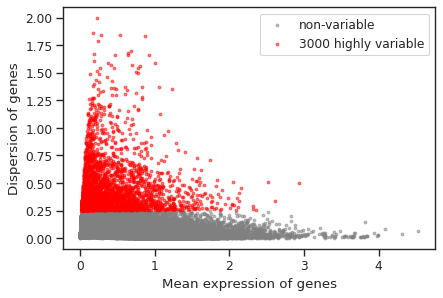

In [3]:
# 上位3000遺伝子を抽出
n_highly_variable = 3000

mean_expressions = df.mean(axis=1)
# 0除算を防ぐ
mean_expressions[mean_expressions == 0] = 1e-12
genes_stats = pd.DataFrame(mean_expressions,
                          index=df.index,
                          columns=['AverageExpr'])
dispersion = df.var(axis=1, ddof=1) / mean_expressions
dispersion[dispersion == 0] = np.nan

genes_stats['Dispersion'] = dispersion
genes_stats

genes_disp = genes_stats.sort_values(by=['Dispersion'], ascending=False)
highly_variable_genes = genes_disp.head(n_highly_variable).index
isHVG = genes_stats.index.isin(highly_variable_genes)

fig, ax = plt.subplots()

# HVGではない遺伝子のプロット
ax.scatter(genes_stats.loc[~isHVG, 'AverageExpr'],
          genes_stats.loc[~isHVG, 'Dispersion'],
          c='gray', s=6, alpha=0.5, label='non-variable')

ax.scatter(genes_stats.loc[isHVG, 'AverageExpr'],
          genes_stats.loc[isHVG, 'Dispersion'],
          c='red', s=6, alpha=0.5, label=f'{n_highly_variable} highly variable')

ax.set_xlabel('Mean expression of genes')
ax.set_ylabel('Dispersion of genes')

plt.legend()
plt.show()

## 高変動遺伝子のHeatmap

In [4]:
# Heatmapの描画にはZ-score化したマトリックスを使う
df = pd.read_csv('GSE54274_rice_leaf_section_average_zscore.csv', index_col=0)
df.head()

,sec1,sec2,sec3,sec4,sec5,sec6,sec7,sec8,sec9,sec10,sec11
Gene,,,,,,,,,,,
LOC_Os01g01010,-0.101962,-0.219561,0.086289,0.234563,-0.666557,-1.485848,-0.954282,0.088353,1.366064,0.669227,0.983714
LOC_Os01g01019,1.078641,1.382486,0.317156,0.498429,0.633129,-0.406207,-0.645919,-0.325709,-1.045244,-0.675301,-0.811462
LOC_Os01g01030,1.356937,1.135305,1.142256,0.767397,-0.046407,-0.253591,-1.043737,-0.504340,-0.370976,-1.014303,-1.168541
LOC_Os01g01040,1.544908,1.526168,0.444886,-0.505822,-0.668609,-0.828859,-0.683871,-0.556475,-0.153620,0.074574,-0.193281
LOC_Os01g01050,-0.856370,0.073759,0.615179,0.190583,1.310424,0.412229,-0.165278,0.571174,-0.562305,-0.889673,-0.699723


/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


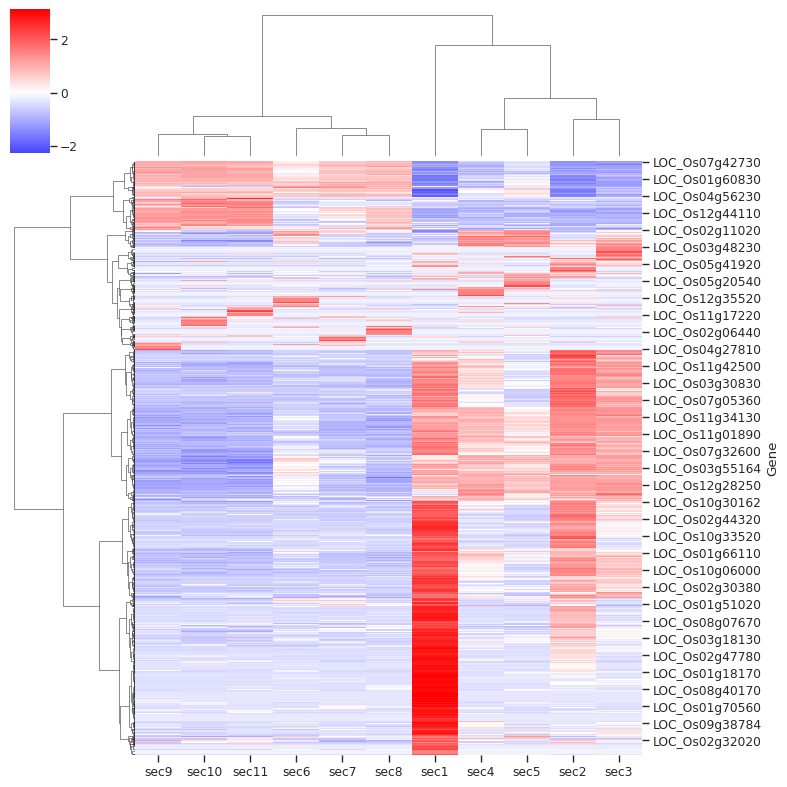

In [5]:
sns.clustermap(
    df[isHVG], method='ward', metric='euclidean', 
    cmap='bwr', center=0, 
    col_cluster=True, row_cluster=True)

クラスター数4を指定

[Text(0.5, 0, 'sec9'),
 Text(1.5, 0, 'sec10'),
 Text(2.5, 0, 'sec11'),
 Text(3.5, 0, 'sec6'),
 Text(4.5, 0, 'sec7'),
 Text(5.5, 0, 'sec8'),
 Text(6.5, 0, 'sec1'),
 Text(7.5, 0, 'sec4'),
 Text(8.5, 0, 'sec5'),
 Text(9.5, 0, 'sec2'),
 Text(10.5, 0, 'sec3')]

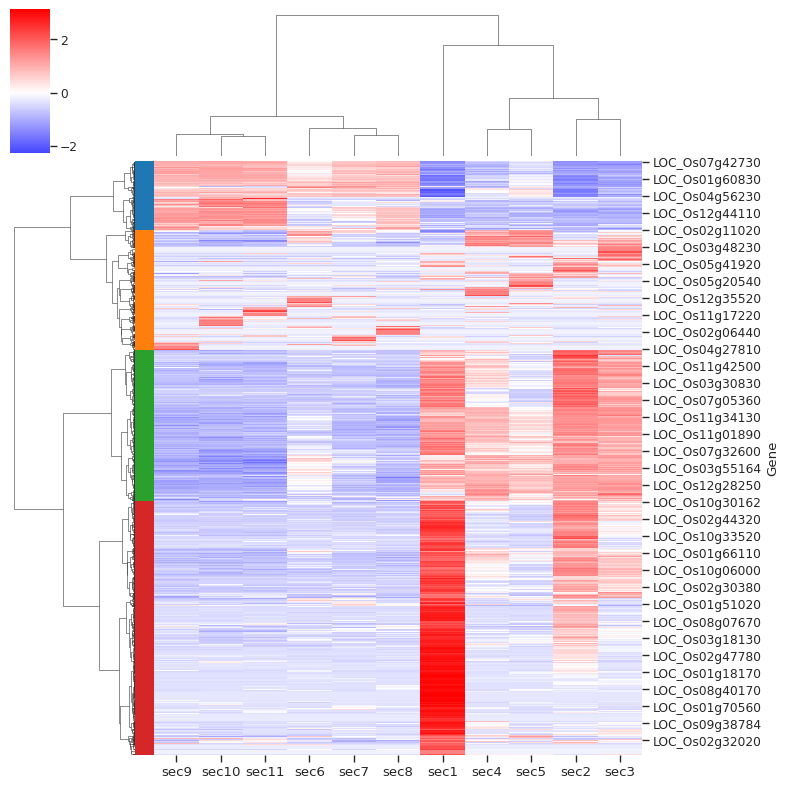

In [6]:
clusters = 4

row_link = linkage(df[isHVG], method='ward', metric='euclidean')
clusters = fcluster(row_link, t=clusters, criterion='maxclust')

cm = plt.cm.get_cmap('tab10')
cluster_colors = list(pd.Series(clusters).map(lambda x: cm.colors[x-1]))

g = sns.clustermap(df[isHVG], 
               row_linkage=row_link,
               row_colors=[cluster_colors],
               method='ward',
               metric='euclidean',
               cmap='bwr',
               center=0,
               col_cluster=True, xticklabels=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12)

- 1番目のクラスター(青色)はsec6からsec11で比較的高発現しており、葉身部分に特異的な遺伝子

- 2番目のクラスターは各セクションそれぞれで高発現する遺伝子

- 3番目のクラスターはsec1からsec5までの葉鞘部分で特異的な遺伝子

- 4番目のクラスターは葉の基部部分(sec1およびsec2)で高発現している遺伝子

以上、イネ第３葉のトランスクリプトームは、まず第一に葉身、葉鞘で大きく異なっていることが分かった。
また、各セクションごとに特異的な遺伝子群(クラスター2)も見つかったのは興味深い。
sec1は特に他のセクションとの差異が大きいように見える

In [7]:
# 各クラスターに属する遺伝子リストが欲しいときは以下のようにする
# 例えばクラスター2の遺伝子についてさらに調べたい時
cluster1_genes = list(df[isHVG][clusters == 2].index)
print(f'cluster2の遺伝子数 {len(cluster1_genes)}')

cluster2の遺伝子数 602


参考

実験医学別冊
独習　Pythonバイオ情報解析

https://www.yodosha.co.jp/yodobook/book/9784758122498/